In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

In [ ]:
data = pd.read_csv('../../../data/kc_house_data_update4.csv')

In [9]:
def relevants(data):
    rel = []
    for col in data.columns:
        if data[col].dtype != object:
            rel.append(col)
    return rel

def graphs(data):
    relevant = relevants(data.drop('price', axis = 1))
    rowsplot = int(len(relevant)/2 + 1)

    fig, axes = plt.subplots(nrows = rowsplot, ncols = 2, figsize=(20, 130))

    for col, ax in zip(relevant, axes.flatten()):
        sns.scatterplot(data = data, x = col, y = 'price', ax = ax)
        ax.set_title(col, fontsize = 20)
        
def make_corrs(data, display = False):
    corrs = data.corr().stack().reset_index()
    corrs = corrs.loc[corrs['level_0'] != corrs['level_1']]
    corrs['pair'] = corrs['level_0'] + ' '+ corrs['level_1']
    corrs['pair'] = corrs['pair'].map(lambda x: ', '.join(sorted(x.split(' '))))
    corrs.drop_duplicates(subset = 'pair', inplace = True)
    corrs.drop(['level_1','level_0'], axis = 1, inplace = True)
    corrs.set_index('pair', inplace = True)
    corrs.columns = pd.Series('correlation')
    corrs = abs(corrs).sort_values('correlation', ascending = False)
    if display:
        display(corrs)
    return corrs

def make_high_corrs(data, display = False):
    corrs = make_corrs(data)
    high_corrs = corrs.loc[corrs['correlation']>= 0.75]
    if display:
        display(high_corrs)
    return high_corrs

def make_corrs_with_price(data, display = False):
    corrs = make_corrs(data)
    corrs_with_price = corrs.loc[corrs.index.str.contains('price')]
    if display:
        display(corrs_with_price)
    return corrs_with_price

def check_homoscedastic(data, display = False):
    results = []
    for col in data.drop('price', axis = 1).columns:
        lower = data[col].quantile(0.45)
        upper = data[col].quantile(0.55)
        mids = data.loc[(data[col] >= lower)&(data[col] <= upper)].index

        index = [x for x in data.index if x not in mids]
        formula = f'price~{col}'
        model = smf.ols(formula = formula, data = data).fit()

        results.append((col, sms.het_goldfeldquandt(model.resid.iloc[index], model.model.exog[index])[1]))

    heteroscedastic = [(col, p) for col, p in results if p < 0.05]
    if display:
        print(heteroscedastic)
    
    return heteroscedastic, results

def corr(x, y):
    xbar = x.mean()
    ybar = y.mean()
    return sum((x-xbar)*(y-ybar))/np.sqrt(sum((x-xbar)**2)*sum((y-ybar)**2))



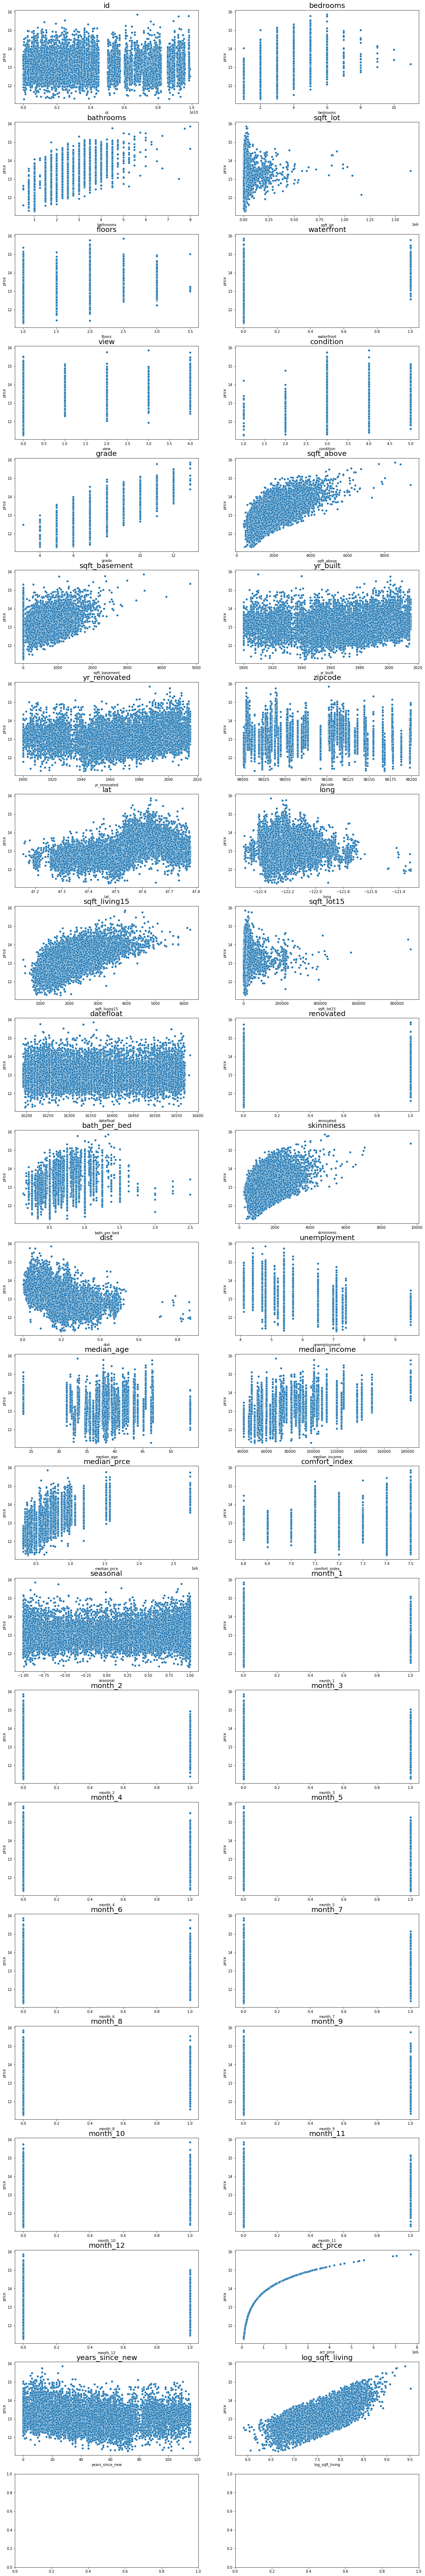

In [10]:
graphs(data)

In [11]:
poly = PolynomialFeatures(2)
data_cop = data.drop(['price','date','zipcode','datefloat','act_prce'], axis = 1)
poly.fit(data_cop)
X = pd.DataFrame(poly.transform(data_cop), columns = poly.get_feature_names(data_cop.columns), index = data_cop.index)
y = data['price']
print(len(X.columns))
linreg = LinearRegression()

903


In [12]:
def five_fold(X, y, say = False):
    if say:
        print('KFOLDS')
    folds = KFold(n_splits = 5, shuffle = True)
    trains = []
    tests = []
    count = 0
    for tr_ind, te_ind in folds.split(X):
        X_train, X_test = X.iloc[tr_ind], X.iloc[te_ind]
        y_train, y_test = y.iloc[tr_ind], y.iloc[te_ind]
        linreg.fit(X_train, y_train)
        trains.append(linreg.score(X_train, y_train))
        tests.append(linreg.score(X_test, y_test))
        count +=1

    return sum(trains)/5, sum(tests)/5
    
five_fold(X[['grade', 'log_sqft_living', 'median_prce comfort_index', 'median_prce^2', 'years_since_new^2', 'yr_renovated lat', 'condition years_since_new', 'yr_built', 'sqft_lot yr_built', 'waterfront log_sqft_living', 'median_income^2', 'sqft_living15 bath_per_bed', 'unemployment median_age', 'median_age month_4', 'sqft_above log_sqft_living', 'long median_income', 'grade median_income', 'floors bath_per_bed', 'grade long', 'view comfort_index', 'grade month_3', 'sqft_lot median_prce']], y)

(0.8727752197733732, 0.8722694062697286)

In [13]:
import copy
def find_best(X, y, initial):
    while 1:
        changed = 0
        init_train, init_test = five_fold(X[initial], y)
        print(initial)
        addition = 0
        added = ''
        for col in X.drop(initial, axis = 1).columns:
            new = copy.copy(initial)
            new.append(col)
            train_sc, test_sc = five_fold(X[new], y)
            if (test_sc > addition) and (test_sc > init_test) and (abs(test_sc - train_sc) < 0.07):
                addition = test_sc
                added = col
        if addition != 0:
            changed = 1
            initial.append(added)
            print(f'Added {added} with score {addition}')
        
        init_train, init_test = five_fold(X[initial], y)
        print(initial)
        removal = 0
        removed = ''
        for col in initial:
            new = copy.copy(initial)
            new.remove(col)
            train_sc, test_sc = five_fold(X[new], y)
            if (test_sc > removal) and (test_sc > init_test) and (abs(test_sc - train_sc) < 0.07):
                removal = test_sc
                removed = col
        if removal != 0:
            changed = 1
            initial.remove(removed)
            print(f'Removed {removed} with score {removal}')
        
        if changed == 0:
            break
    print(initial)

In [14]:
X.columns

Index(['1', 'id', 'bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'waterfront',
       'view', 'condition', 'grade',
       ...
       'month_11^2', 'month_11 month_12', 'month_11 years_since_new',
       'month_11 log_sqft_living', 'month_12^2', 'month_12 years_since_new',
       'month_12 log_sqft_living', 'years_since_new^2',
       'years_since_new log_sqft_living', 'log_sqft_living^2'],
      dtype='object', length=903)

In [15]:
inits = ['grade', 'log_sqft_living', 'median_prce comfort_index', 'median_prce^2', 'years_since_new^2', 'yr_built', 'sqft_lot yr_built', 'waterfront log_sqft_living', 'median_income^2', 'long median_income', 'grade median_income', 'floors bath_per_bed', 'grade month_3', 'sqft_lot median_prce', 'sqft_lot^2', 'view', 'median_income median_prce', 'median_income comfort_index', 'comfort_index^2', 'yr_built comfort_index', 'median_age median_prce', 'grade lat', 'skinniness years_since_new', 'condition median_age', 'yr_renovated log_sqft_living', 'sqft_living15 years_since_new', 'grade log_sqft_living', 'bathrooms sqft_lot', 'condition median_income', 'sqft_above bath_per_bed', 'years_since_new log_sqft_living', 'long month_1', 'grade month_2', 'sqft_living15', 'view long', 'lat median_income', 'view dist', 'median_income month_4', 'view median_prce', 'unemployment years_since_new', 'bath_per_bed unemployment', 'lat comfort_index', 'yr_built month_4']
find_best(X, y, inits)

['grade', 'log_sqft_living', 'median_prce comfort_index', 'median_prce^2', 'years_since_new^2', 'yr_built', 'sqft_lot yr_built', 'waterfront log_sqft_living', 'median_income^2', 'sqft_living15 bath_per_bed', 'unemployment median_age', 'median_age month_4', 'sqft_above log_sqft_living', 'long median_income', 'grade median_income', 'floors bath_per_bed', 'grade long', 'grade month_3', 'sqft_lot median_prce', 'view long', 'sqft_lot^2', 'view', 'median_income median_prce', 'median_income comfort_index', 'comfort_index^2', 'yr_built comfort_index', 'median_age median_prce', 'grade lat', 'skinniness years_since_new', 'condition median_age', 'yr_renovated log_sqft_living', 'sqft_living15 years_since_new', 'grade log_sqft_living', 'sqft_living15^2', 'bathrooms sqft_lot', 'condition median_income']
Added sqft_basement^2 with score 0.8800416425554785
['grade', 'log_sqft_living', 'median_prce comfort_index', 'median_prce^2', 'years_since_new^2', 'yr_built', 'sqft_lot yr_built', 'waterfront log_sq

KeyboardInterrupt: 